Synthetic Difference-in-Differences

https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html

Here you can see what it looks like for the Proposition 99 data:

In [4]:
import numpy as np
import pandas as pd
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

pd.set_option('display.max_columns', 10)

In [2]:
#pip install cvxpy


In [3]:
data = (pd.read_csv("smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [4]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


If we want to go from this table to the matrix representation we discussed earlier, all we have to do is pivot the table by time (year) and unit (state). We’ll be going back and forth between these two representations, as one is more convenient for DiD and the other, for Synthetic Controls estimation.

In [5]:
data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


Diff-in-Diff Revisited

In [6]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


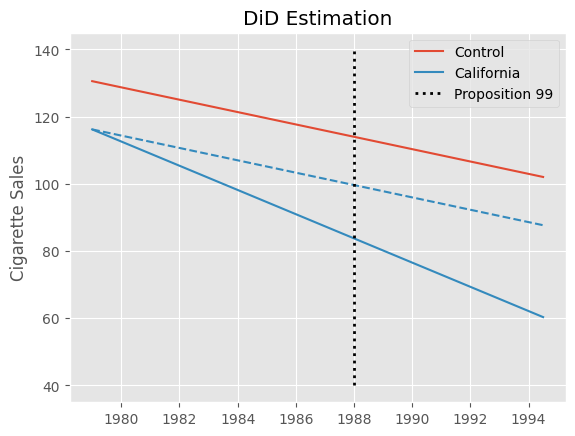

In [7]:
pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

This estimate should be taken with a grain of salt, though. We know that Diff-in-Diff requires the trend in the control group to be equal to that of the treated group in the absence of the treatment.

Specifically, we can see that the trend in cigsale for California is not parallel to the other states, at least in the pre-treatment periods. Cigarette sales in California are decreasing faster than the average of the control states, even prior to the treatment. If this trend extends beyond the pre-treatment period, the DiD estimator will be downward biased, meaning that the true effect is actually less extreme than the one we’ve estimated above.

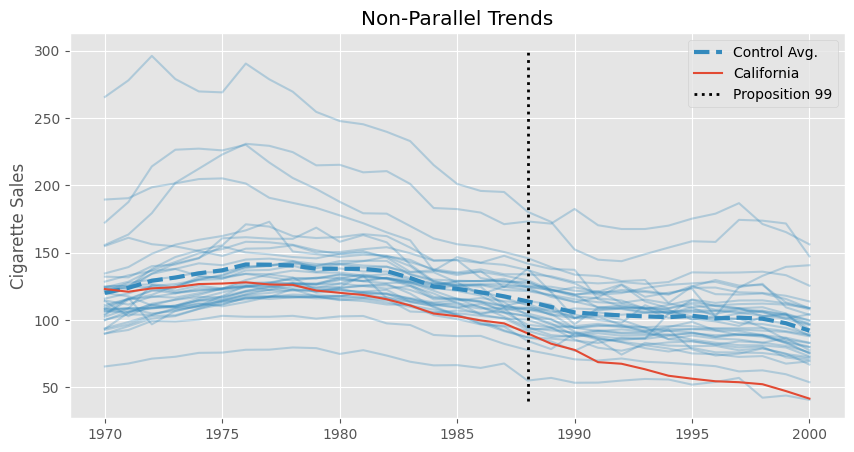

In [8]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

The problem of non-parallel trends is where Synthetic Control comes into play in the Synthetic Diff-in-Diff model. But we are getting ahead of ourselves. Regardless of DiD being a valid model for the data above, what is interesting about it is that we can recast it into the Two-Way Fixed-Effects formulation. To frame DiD like this, we fit unit () and time () averages, alongside the treatment indicator.

After demeaning, a simple regression of the outcome on the treatment indicator (treat*post) yields the difference in difference estimator.

In [9]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


As you can see, we get the exact same parameter as before. After all, both approaches are simply different ways of looking at the same DiD estimator. However, the reason this formulation is much more interesting for our purpose is that it allows us to see how DiD is actually quite similar to Synthetic Controls. Take a very close look at the TWFE formulation above. Notice that it is a regression problem with time effects and unit effects. But notice how there are no weights in the optimization objective. That is the main difference between Diff-in-Diff and Synthetic Controls, as we will see shortly.

Synthetic Controls Revisited

In [5]:
import cvxpy as cp
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment").query("~treated").pivot("year", "state", "cigsale")
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot("year", "state", "cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

ModuleNotFoundError: No module named 'sc'

In [11]:
pip install sc

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sc (from versions: none)
ERROR: No matching distribution found for sc
